In [1]:
import matplotlib.pyplot as plt
import numpy as np

from spikit import *

In [3]:
binary = Binary(1e4, 10)
spike = StaticPowerLaw(1e4, 10, 7/3, 5.448e15)

gw = GravitationalWaves(binary)
df = DynamicalFrictionIso(spike)
acc = AccretionIso(spike)

risco = binary.Risco()

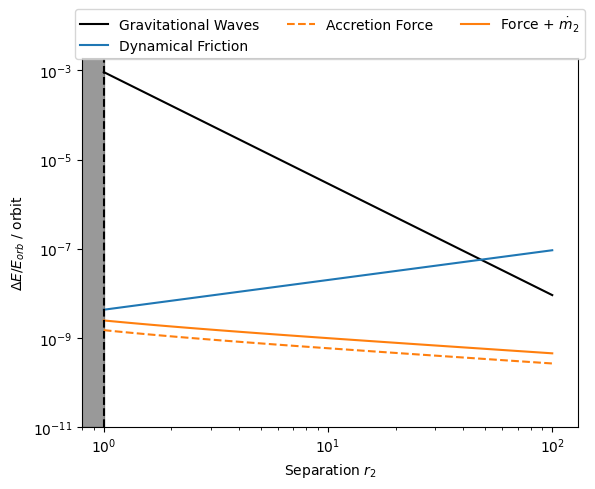

In [19]:
# Print the change to the energy for each force.
# At first order for the static case we can ignore changes to the mass for the plotting.
a = np.logspace(0, 2) *risco # [pc]
u = binary.u(a) # [m/s]

plt.loglog(a/risco, gw.dE_dt(a, 0)/-binary.Eorb(a) *binary.T(a), c = "black", label = "Gravitational Waves")
plt.loglog(a/risco, np.vectorize(df.dE_dt)(a, u)/-binary.Eorb(a) *binary.T(a), label = "Dynamical Friction")
plt.loglog(a/risco, np.vectorize(acc.dE_dt)(a, u)/-binary.Eorb(a) *binary.T(a), label = "Accretion Force", ls = "--", c = "C1")

# Beware! For the full energy loss, the accretion of mass should also be included.
# This is an approximate calculation, at O(q) accuracy.
# When calculating the orbit, dadt takes in the dEdt from the force AND the mass loss rate to figure things on its own.
dEdt_acc_total = np.vectorize(acc.dE_dt)(a, u) -binary.Eorb(a, m2 = np.vectorize(acc.dm2_dt)(a, u))
plt.loglog(a/risco, dEdt_acc_total/-binary.Eorb(a) *binary.T(a), label = "Force + $\dot{m}_2$", c = "C1")

plt.axvline(1, c = "black", ls = "--")
plt.axvspan(1, 0.5, color = "black", alpha = 0.4)
plt.xlim(left = 0.8)
plt.ylim(bottom = 1e-11)

plt.ylabel("$\Delta E / E_{orb}$ / orbit")
plt.xlabel("Separation $r_2$")

plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.15), ncol = 3)

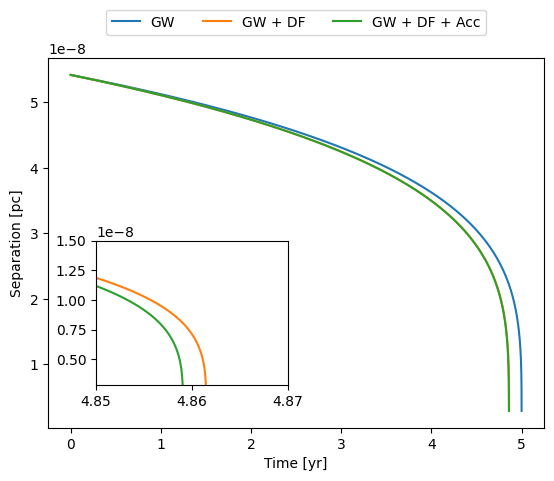

In [21]:
# We can use DynamicSolver to solve the coupled equations of motion with a dynamic time-grid.
# The time-grid is automatically adjusted to keep the orbit stable based on h, the maximum allowed relative change in the separation.
results_gw = DynamicSolver(binary, loss = gw).solve(VacuumMerger(binary).r(5 *yr), h = 1e-3)
results_df = DynamicSolver(binary, loss = [gw, df]).solve(VacuumMerger(binary).r(5 *yr), h = 1e-3)
results_all = DynamicSolver(binary, loss = [gw, df, acc]).solve(VacuumMerger(binary).r(5 *yr), h = 1e-3)

plt.plot(results_gw["t"]/yr, results_gw["a"], label = "GW")
plt.plot(results_df["t"]/yr, results_df["a"], label = "GW + DF")
plt.plot(results_all["t"]/yr, results_all["a"], label = "GW + DF + Acc")

plt.xlabel("Time [yr]")
plt.ylabel("Separation [pc]")
# The legend should be placed outside the plot, at the top.
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.15), ncol = 3)

# =============================================================================
plt.axes([0.2, 0.2, 0.3, 0.3])

plt.plot(results_df["t"]/yr, results_df["a"], c = "C1")
plt.plot(results_all["t"]/yr, results_all["a"], c = "C2")
plt.xlim(4.85, 4.87)
plt.ylim(risco, 1.5e-8);